# OKMesoPy Module Usage Examples

OKMesoPy is a tool developed to assist with downloading and manipulating the Oklahoma Mesonet climate dataset. Mesonet provides a rich source of historic climate data and 5 minute sampling variables. A full list of all the variables collected by Mesonet can be found here: https://www.mesonet.org/index.php/site/about/mdf_mts_files.

The original script was written with the intention of creating timeseries for use with PyHSPF but the Mesonet dataset could be used for any number of climatological, meteorological, or hydrological research. This notebook provides examples of how to use the module and some explanation of how it works.

In [1]:
# Imports
import os, urllib.request, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from okmesopy import MesonetDownloader, MesonetTools
from shapefile import Reader

## MesonetDownloader Class

MesonetDownloader is the class that performs all of the module's downloading and time series generation functions. The MesonetDownloader initialization function has two optional parameters:
- destination: This is the directory where MesonetDownloader will save files downloaded from Mesonet. If no argument is given, it will default to the current directory.
- verbose: This is a boolean argument that determines whether or not verbose logging will be sent to stdout. False by default.

Upon initialization, MesonetDownloader checks for the metadata file in the destination directory and if not found attempts to download it from Mesonet. Because the metadata file is essential for performing all other functions, a FileNotFoundError will he raised if it cannot be loaded.

In [2]:
# set the destination to this notebook's directory
destination = os.getcwd()
downloader = MesonetDownloader(destination, verbose = False)
tools = MesonetTools(verbose = True)

The metadata file is the "Site Location/Soil Info (CSV)" file from https://www.mesonet.org/index.php/site/sites/mesonet_sites. At that URL a shapefile with all the Mesonet sites can also be downloaded. The metadata file can be accessed directly using the "metadata" variable of a MesonetDownloader object. The metadata file contains information about each station including the name, ID, location, soil information, date of commission, and date of decommission if applicable. A full description of each variable in the metadata file can be found here: https://www.mesonet.org/index.php/site/about/site_location_information.

In addition to accessing the metadata directly, the MesonetDownloader class has two methods to retrieve metadata:
- get_station_ids()
- get_station_coord(site_id)

**get_station_ids()** simply prints a list of all the available station IDs. A valid station ID is required for many functions.

**get_station_coord(site_id)** takes one of the station IDs as an argument and returns the coordinates of the station as a tuple in the form (latitude, longitude). This can be useful when doing geospatial analysis of the climate data.

In [3]:
print('Valid site IDs are:')
print(downloader.get_station_ids())
stid = 'ACME'
print('\nThe coordinates of the {} station are {}.'.format(stid,downloader.get_station_coord(stid)))

Valid site IDs are:
ADAX ALTU ALV2 ALVA ANT2 ANTL APAC ARD2 ARDM ARNE BBOW BEAV BEEX BESS BIXB BLAC BOIS BOWL BREC BRIS BROK BUFF BURB BURN BUTL BYAR CALV CAMA CARL CATO CENT CHAN CHER CHEY CHIC CLAR CLAY CLOU CLRM COOK COPA DURA ELKC ELRE ERIC EUFA EVAX FAIR FITT FORA FREE FTCB GOOD GRA2 GRAN GUTH HASK HECT HINT HOBA HOLD HOLL HOOK HUGO IDAB INOL JAYX KENT KETC KIN2 KING LAHO LANE MADI MANG MARE MARS MAYR MCAL MEDF MEDI MIAM MINC MRSH MTHE NEWK NEWP NINN NORM NOWA NRMN OILT OKCE OKCN OKCW OKEM OKMU PAUL PAWN PERK PORT PRES PRYO PUTN REDR RETR RING SALL SEIL SEMI SHAW SKIA SLAP SPEN STIG STIL STUA SULP TAHL TALA TALI TIPT TISH TULL TULN VALL VANO VINI WAL2 WALT WASH WATO WAUR WEAT WEB3 WEBB WEBR WEST WILB WIST WOOD WYNO YUKO

The coordinates of the ACME station are (34.80833, -98.02325).


### Downloading Data

When MesonetDownloader downloads data, it stores the raw mts files in a folder named mts_files in the destination directory. When using any of the download functions, MesonetDownloader first checks that folder and only downloads files when it cannot find them locally. There are four download functions:
- download_station_data(stid,start_date,end_date)
- download_bounding_box(bbox,start_date,end_date,padding=1)
- download_shape_file(shape_path,start_date,end_date,padding=1,prj_path='')
- download_shape_object(shape,start_date,end_date,padding=1,prj_path='')

All of MesonetDownloader's download functions require a start and end date as datetime date objects.

In [4]:
start_date = date(2021, 2, 1)
end_date = date(2021, 2, 10)

**download_station_data(stid,start_date,end_date)** is the most basic download function. It downloads all the data for a single station over the time period from start_date to end_date. The stid argument is case insensitive.

The following code will download the data for the ACME station from "start_date" to "end_date" and graph the air temperature for that period.

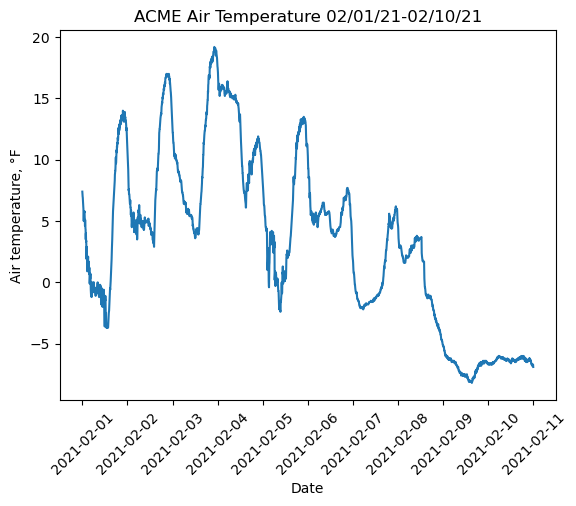

In [5]:
stid = 'acme'
station_data = downloader.download_station_data(stid,start_date,end_date)
plt.plot(station_data['DATETIME'],station_data['TAIR'])
plt.title('{} Air Temperature {}-{}'.format(stid.upper(),start_date.strftime('%m/%d/%y'),end_date.strftime('%m/%d/%y')))
plt.xlabel('Date')
plt.ylabel('Air temperature, °F')
ticks = plt.xticks(rotation = 45)

**download_bounding_box(bbox,start_date,end_date,padding=1)** will download data for all stations within a specificed bounding box. The bbox argument should be a list in the form [low longitude, low latitude, high longitude, high latitude]. This is the same format that the PyShp library uses. Padding is an optional parameter that will increase or decrease the size of the bounding box. This is discussed further in a later example.

This function returns a dictionary where the keys are station IDs and the values are the downloaded dataset for that station.

The following code will download the data for all stations within the specified bounding box and graph the air temperature. Note the large negative values. These are due to error codes within the data and dealing with them will be addressed later in this notebook.

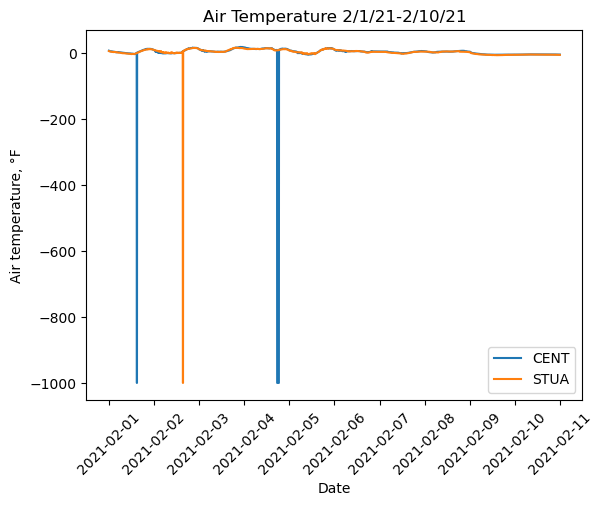

In [6]:
bbox = [-96.5,34,-96,35]
bbox_data = downloader.download_bounding_box(bbox,start_date,end_date)
for key in bbox_data:
    plt.plot(bbox_data[key]['DATETIME'],bbox_data[key]['TAIR'],label=key)
plt.title('Air Temperature 2/1/21-2/10/21')
plt.xlabel('Date')
plt.ylabel('Air temperature, °F')
plt.legend()
ticks = plt.xticks(rotation = 45)

MesonetDownloader provides two methods for working with shapefiles using the pyshp library. Note that both methods simply use the bbox attribute so depending on the shape it may include stations that are outside of the actual shape. These methods also return a dictionary where the keys are the station IDs and the data are the downloaded DataFrames.

**download_shape_file(shape_path,start_date,end_date,padding=1,prj_path='')** expects a path to a .shp file. This function does not require you to import the PyShp module into your code as reading the shapefile is handled within the MesonetDownloader class.

This code will download and unzip the shapefiles that are used in these examples from the Github repository.

In [7]:
# URL where the zipped shapefiles are
git = 'https://github.com/bjrubinstein/okmesopy/blob/main/examples/shapefiles'
# create a directory for the shapefiles
if not os.path.isdir('{}/{}'.format(destination,'shapefiles')): os.mkdir('{}/{}'.format(destination,'shapefiles'))
# names of the two zip files
gl_file = 'grand_lake_watershed.zip'
hc_file = 'horse_creek.zip'
# check if the Grand Lake shape file exists
if not (os.path.exists('{}/shapefiles/grand_lake_watershed/grand_lake_watershed.shp') and 
        os.path.exists('{}/shapefiles/grand_lake_watershed/grand_lake_watershed.prj')):
    # download the zip file if it doesn't exist already
    if not os.path.exists('{}/shapefiles/{}'.format(destination,gl_file)):
        msg = urllib.request.urlretrieve('{}/{}?raw=true'.format(git,gl_file),'{}/shapefiles/{}'.format(destination,gl_file))
    # extract the shape files from the zip
    with zipfile.ZipFile('{}/shapefiles/{}'.format(destination,gl_file),'r') as zip_ref:
        zip_ref.extractall('{}/shapefiles/'.format(destination))
# check if the Horse Creek shape file exists and download if not
if not os.path.exists('{}/shapefiles/horse_creek/horse_creek.shp'):
    if not os.path.exists('{}/shapefiles/{}'.format(destination,hc_file)):
        msg = urllib.request.urlretrieve('{}/{}?raw=true'.format(git,hc_file),'{}/shapefiles/{}'.format(destination,hc_file))
    with zipfile.ZipFile('{}/shapefiles/{}'.format(destination,hc_file),'r') as zip_ref:
        zip_ref.extractall('{}/shapefiles/'.format(destination))

The Mesonet metadata uses the EPSG:4269 coordinate reference system (CRS). It can generally detect if coordinates are not in latitude-longitude and will give a warning if that is the case.

In [8]:
downloader.verbose = True # turn verbose logging on
shape_data = downloader.download_shape_file('{}/shapefiles/grand_lake_watershed/grand_lake_watershed.shp'.format(destination),start_date,end_date)

It appears that the bounding box [-123028.0390625, 1478977.375, 213226.515625, 1760277.875] is not in latitude longitude coordinates. Try specifing the prj_path argument when calling this function.


If the optional "prj_path" argument is specified, MesonetDownloader will automatically read the shapefile's CRS and convert it to the correct one. The following code will convert the coordinates in the provided shapefile to the correct format, download the for all the stations, and print a list of all the stations for which data was downloaded.

NOTE: If you do not have the MTS files downloaded already, the verbose logging will print every file that is being downloaded. Running the cell again with the files already downloaded will just print the verbose message about the CRS being converted and then the list of stations.

In [9]:
shape_data = downloader.download_shape_file('{}/shapefiles/grand_lake_watershed/grand_lake_watershed.shp'.format(destination),start_date,end_date,prj_path='{}/shapefiles/grand_lake_watershed/grand_lake_watershed.prj'.format(destination))
num_stations = len(shape_data)
stids = ''
for key in shape_data: stids += ' {}'.format(key)
print('Downloaded data for {} stations within the shape file: {}'.format(num_stations,stids))

Transforming bounding box from EPSG:5069 to EPSG:4269.
Downloaded data for 15 stations within the shape file:  BLAC BURB COPA FORA JAYX MIAM NEWK NOWA PAWN PRYO REDR SKIA TALA VINI WYNO


**download_shape_object(shape,start_date,end_date,padding=1,prj_path='')** is the other function for downloading data within a shapefile. It expects a pyshp Reader or Shape object for the shape argument.

As previously mentioned, "padding" is an optional argument that will increase or decrease the size of the bounding box (recall that the shape download functions use the shape's bounding box attribute). If no stations are found and the verbose attribute is true you will get a message suggesting that the padding argument be increased.

In [10]:
shp_path = '{}/shapefiles/horse_creek/horse_creek.shp'.format(destination)
sf = Reader(shp_path)
obj_data = downloader.download_shape_object(sf,start_date,end_date)

No stations found within the bounding box.
[-94.99976083200346, 36.634247035429745, -94.83198491219673, 36.78026945461582]
Try increasing the padding argument.


When the "padding" argument is specified the length of each side of the bounding box is multiplied by it. The increase in length happens equally in all directions, i.e. the center of the bounding box remains the same. The following code will download the data for all the stations within the bounding box of the provided shape file multiplied by the "padding" argument.

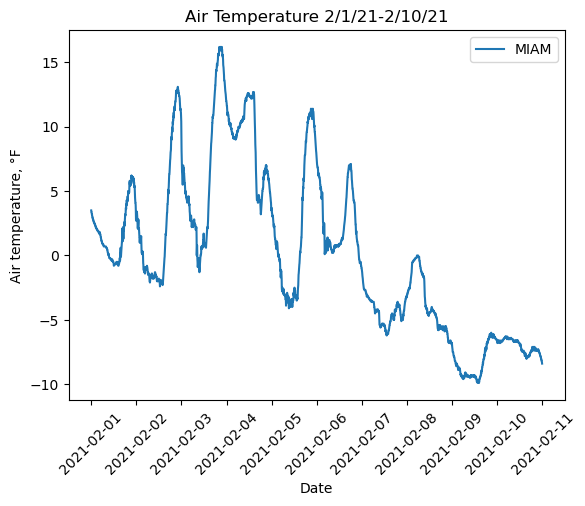

In [11]:
padding = 2
downloader.verbose = False
obj_data = downloader.download_shape_object(sf,start_date,end_date,padding)
sf.close()
for key in obj_data:
    plt.plot(obj_data[key]['DATETIME'],obj_data[key]['TAIR'],label=key)
plt.title('Air Temperature 2/1/21-2/10/21')
plt.xlabel('Date')
plt.ylabel('Air temperature, °F')
plt.legend()
ticks = plt.xticks(rotation = 45)

## MesonetTools Class
The MesonetTools class contains methods for handling missing data and saving downloaded data into different formats. The initialization function has one optional parameter:
- verbose: Equivalent to the verbose argument in the MesonetDownloader class, this is a boolean argument that determines whether or not verbose logging will be sent to stdout. False by default.

### Handling Missing Data
MesonetTools provides four methods that deal with missing data: one to describe the missing data and three to handle it.
- summarize_missing(df,graph=False)
- replace_errors(df,code=1,column=None)
- interpolate_missing(df,codes=[],column=None)
- fill_neighbor_data(df,downloader,codes=[],column=None)

Missing data is represented by the error codes -995 to -999. A description of each error code can be found by running help(MesonetTools.replace_errors) or at the following link: https://www.mesonet.org/index.php/site/about/mdf_mts_files.

In [12]:
help(MesonetTools.replace_errors)

Help on function replace_errors in module okmesopy.mesonettools:

replace_errors(self, df, code=1, column=None)
    Replace error codes in the dataset with NaN.
    
    Description of error codes:
        -999 - flagged bad by QA routines
        -998 - sensor not installed
        -997 - missing calibration coefficients
        -996 - station did not report
        -995 - data not reported on this time interval
        -994 - value is too wide to fit in column
    arguments:
        df (DataFrame or dict): the dataframe or dictionary of dataframes
            to be manipulated
        code (int): the specific error code to be replaced, the default 1
            replaces all error codes
        column (str): optional parameter that when specified changes only
            a single column
    
    returns:
        DataFrame or dict: the modified df object



**summarize_missing(df,graph=False)** prints a summary of all the missing data in the provided DataFrame. Note that the "df" argument in this function must be a single DataFrame, not a dictionary of DataFrames. If the optional "graph" argument is set to true then the Missingno library will be used to display a graphical depiction of the missing data.

Missing data summary for ACME station:
-----------------------
To see a description of each error code run help(MesonetTools.replace_errors)
Note: the -995 error code is used when data is not collected on an interval. This code is generally normal and expected.
There are 82900.0 total missing data points and 49300.0 missing data data points excluding -995 codes
The following chart displays the number of each kind of error code found in each column of the DataFrame.

       -994     -995  -996  -997  -998    -999    TOTAL
RELH    0.0      0.0   0.0   0.0   0.0     0.0      0.0
TAIR    0.0      0.0   0.0   0.0   0.0     0.0      0.0
WSPD    0.0      0.0   0.0   0.0   0.0   534.0    534.0
WVEC    0.0      0.0   0.0   0.0   0.0   534.0    534.0
WDIR    0.0      0.0   0.0   0.0   0.0   534.0    534.0
WDSD    0.0      0.0   0.0   0.0   0.0   534.0    534.0
WSSD    0.0      0.0   0.0   0.0   0.0   534.0    534.0
WMAX    0.0      0.0   0.0   0.0   0.0   534.0    534.0
RAIN    0.0      0.0   0.

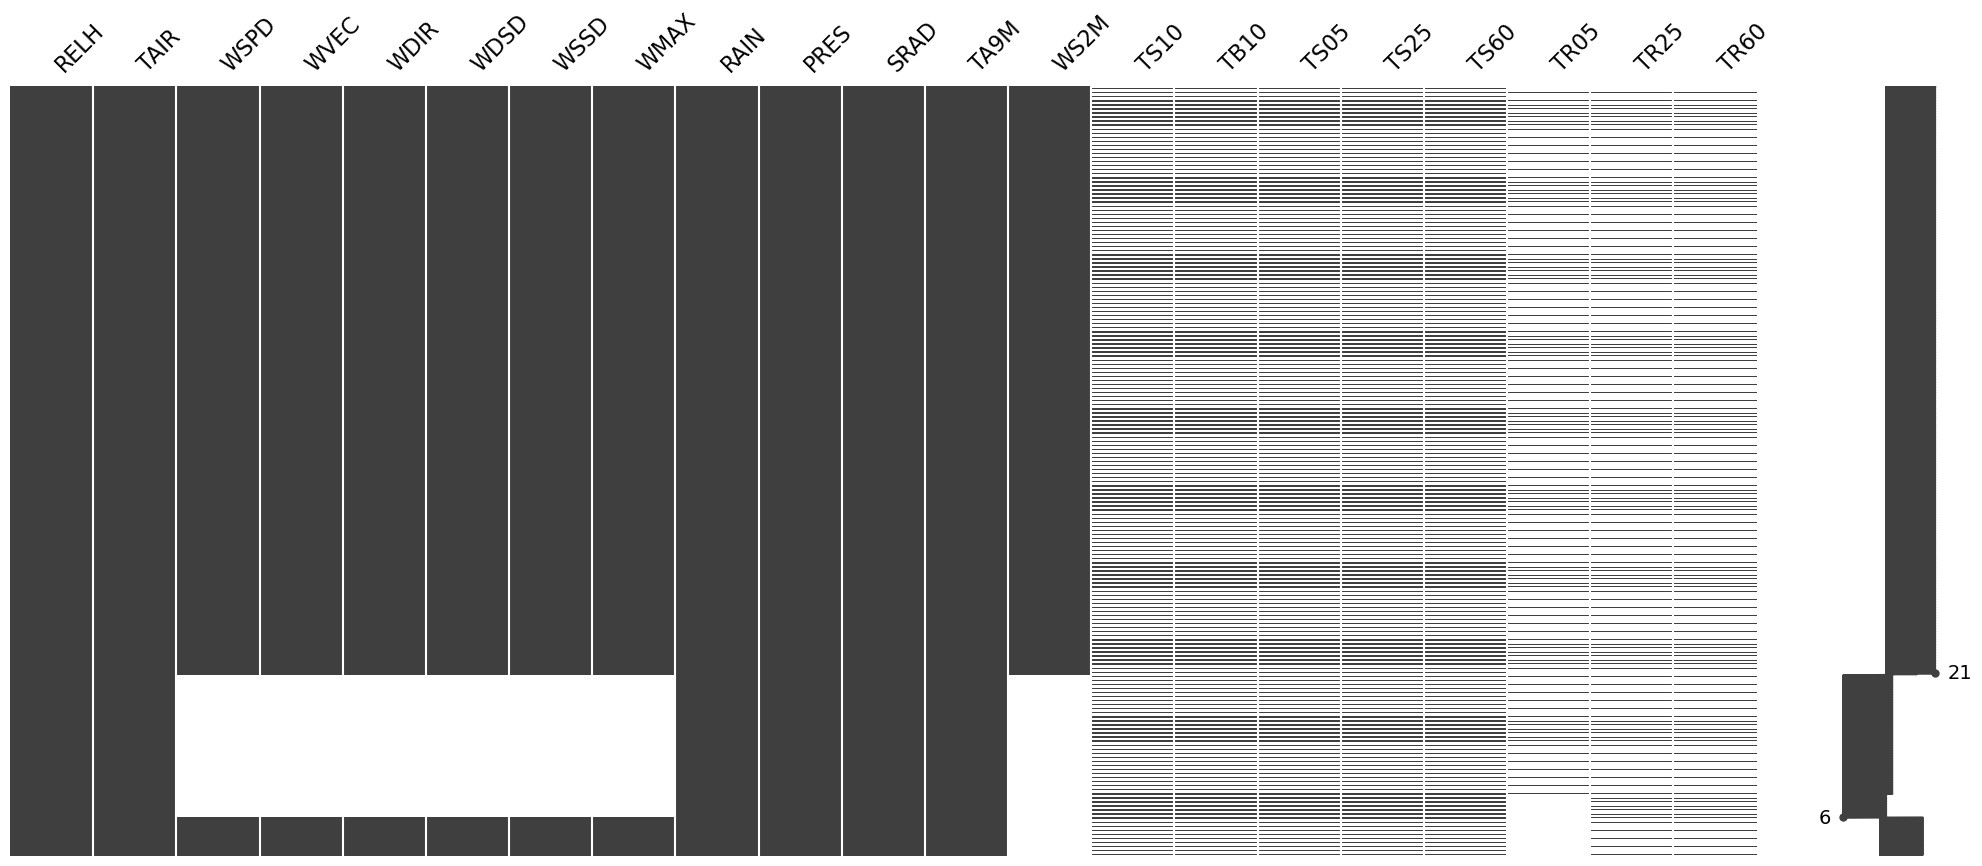

In [13]:
tools.summarize_missing(station_data,graph=True)

We can see many -995 errors for the soil temperature and moisture data which is expected as they are collected on longer intervals than 5 minutes. We also see a period of time for the wind speed data that is missing with -999 errors. This means that the data failed quality control checks for this period.

**replace_errors(df,code=1,column=None)** is the simplest way to handle missing data. It replaces the error codes with NaN. Note, this function accepts either a single DataFrame for a dictionary of DataFrames for the "df" argument. If the optional "code" argument is given then only that single error code is replaced, otherwise all error codes are replaced. Similarly the optional "column" argument is given then error codes is only replaced in that specfied column, otherwise it is replaced in all columns.

The **replace_errors** method works best when there are a small number of errors. Let's revisit the dataset we downloaded with the **download_bbox** method. The following code removes the error codes and graphs the air temperatures. Note how we now get a smooth graph as only a few points were missing.

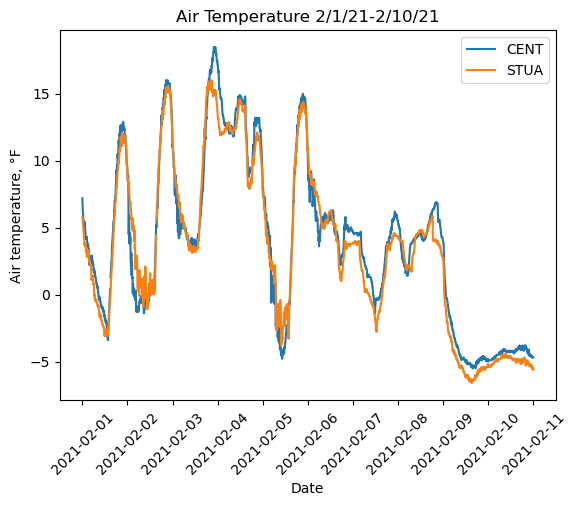

In [14]:
rep_data = tools.replace_errors(bbox_data)
for key in bbox_data:
    plt.plot(rep_data[key]['DATETIME'],rep_data[key]['TAIR'],label=key)
plt.title('Air Temperature 2/1/21-2/10/21')
plt.xlabel('Date')
plt.ylabel('Air temperature, °F')
plt.legend()
ticks = plt.xticks(rotation = 45)

**interpolate_missing(df,codes=[],column=None)** uses simple linear interpolation to filling missing data values. Similar to the **replace_errors** function, "df" can be a single DataFrame of a dictionary of DataFrames. In this function "codes" is an optional argument that expects a list of all the error codes to be replaced with interpolated data. If "codes" is specified other error codes are ignore for the interpolation calculations. Similar to the **replace_errors** function the optional "column" argument is given then error codes is only replaced in that specfied column, otherwise it is replaced in all columns.

The **interpolate_missing** can be useful for filling in occasional missing data points or smoothing data missing due to -995 error codes. For example, soil temperature at 10 cm under native vegetation (TS10) is logged on 15 minute intervals. The following code interpolates between the logged data and plots the result.

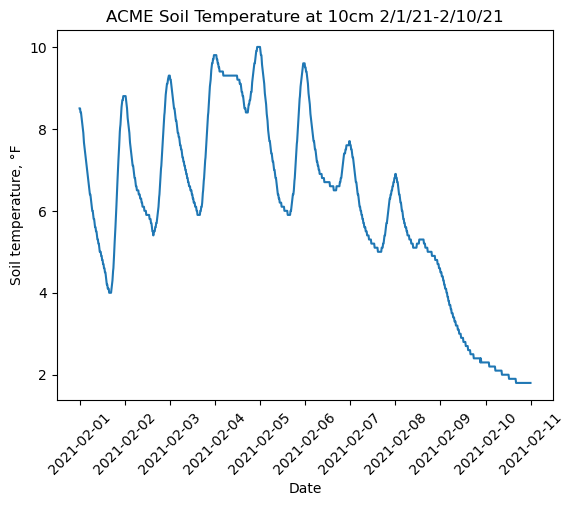

In [15]:
st_int_data = tools.interpolate_missing(station_data)
plt.plot(st_int_data['DATETIME'],st_int_data['TS10'])
plt.title('{} Soil Temperature at 10cm 2/1/21-2/10/21'.format(stid.upper()))
plt.xlabel('Date')
plt.ylabel('Soil temperature, °F')
ticks = plt.xticks(rotation = 45)

**fill_neighbor_data(df,downloader,codes=[],column=None)** replaces missing data with data from the nearest reporting station. The arguments are the same as for the **interpolate_missing** function except that there is an additional required "downloader" argument. This expects a MesonetDownloader object as the it needs to be able to downloaded data from neighboring stations. The **fill_neighbor_data** automatically ignores -995 errors. Because those are due to data collected on longer intervals they occur at the same times for every station.

This method can be useful when a large amount of data is missing for a particular station. In the missing data summary we saw that there was a period of wind speed data missing due to failing quality checks (-999 errors). The following code will use this method to replace that missing data and graph it as well as the interpolated data for comparison.

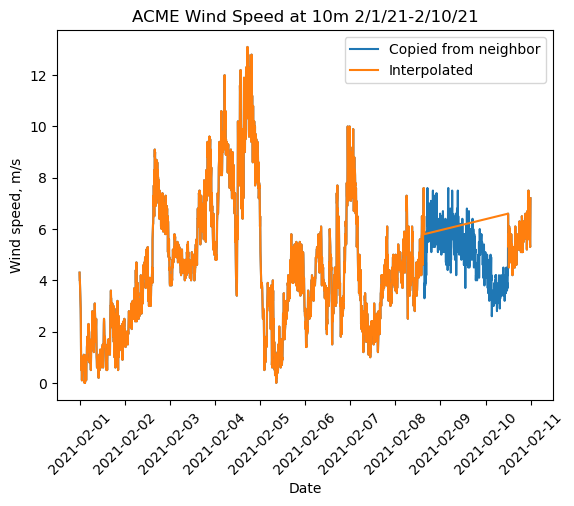

In [16]:
st_nei_data = tools.fill_neighbor_data(station_data,downloader)
plt.plot(st_nei_data['DATETIME'],st_nei_data['WSPD'],label='Copied from neighbor')
plt.plot(st_int_data['DATETIME'],st_int_data['WSPD'],label='Interpolated')
plt.title('{} Wind Speed at 10m 2/1/21-2/10/21'.format(stid.upper()))
plt.xlabel('Date')
plt.ylabel('Wind speed, m/s')
plt.legend()
ticks = plt.xticks(rotation = 45)

### Saving/Exporting Data
MesonetTools provides two methods for saving/exporting data.
- save_timeseries(df,column,step=5)
- save_csv(df,path,force=False,filename='')

**save_timeseries(df,column,step=5)** exports data as a tuple in a PyHSPF readable format. The format is (date.datetime,integer,series) where the first value is the start time of the series, the second is the step size between data in minutes, and the last is a series of the actual data points. The "df" argument can be a DataFrame or a dictionary of DataFrames. "column" is the name of column for which a timeseries is wanted. "step" is the step size in minutes. It must be at least 5 and also divisible by 5. It will be rounded up to the nearest multiple of 5 if not.

If a dictionary is given then the arithmatic mean of all stations for each data point is calculated. Combining this method with the either of the shapefile download methods provides a quick way to do geospatial averaging of climate data. The following code generates an averaged timeseries of the data previously downloaded with the **download_bounding_box** method. It then generates a list of the datetimes and graphs it against the individual stations.

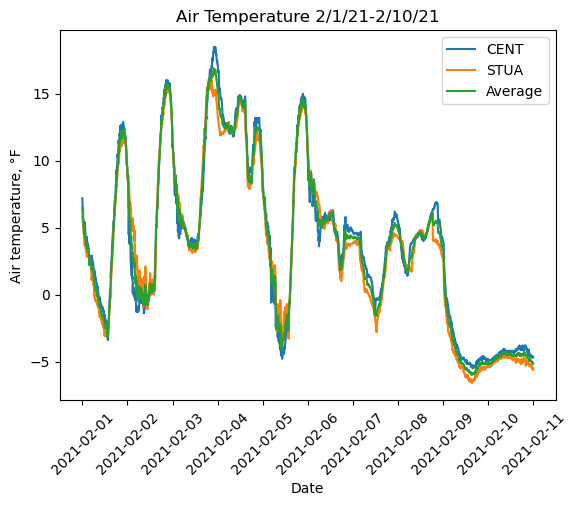

In [17]:
series = tools.save_timeseries(bbox_data,'TAIR')
start = series[0]
timestep = timedelta(minutes=series[1])
times = []
for x in range(0,len(series[2])):
    times.append(start + timestep*x)
for key in rep_data:
    plt.plot(rep_data[key]['DATETIME'],rep_data[key]['TAIR'],label=key)
plt.plot(times,series[2],label='Average')
plt.title('Air Temperature 2/1/21-2/10/21')
plt.xlabel('Date')
plt.ylabel('Air temperature, °F')
plt.legend()
ticks = plt.xticks(rotation = 45)

**save_csv(df,path,force=False,filename='')** saves data to a CSV file. "df" is the DataFrame or dictionary of DataFrames to be saved. If a dictionary is given, all the individual DataFrames are concatenated and saved to a single file. "path" is the path to the directory where the CSV will be saved. "force" tells the method whether or not to overwrite the file if it already exists. "filename" is an optional argument for the name of the CSV file. The filename argument can only contain alphanumeric characters, hyphens, underscores, and periods. If not provided an automatically generated filename will be used.

The following code will save the dataset from the **download_shape_file** method to the current working directory.

In [18]:
tools.save_csv(bbox_data,destination,force=True)